In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from fastai.tabular import *
import scipy.signal as s

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
path.ls()

[WindowsPath('data/LFP_Prediction/.ipynb_checkpoints'),
 WindowsPath('data/LFP_Prediction/ims'),
 WindowsPath('data/LFP_Prediction/lfp_labels.csv'),
 WindowsPath('data/LFP_Prediction/lfp_labels_new.csv'),
 WindowsPath('data/LFP_Prediction/lfp_labels_new_data.csv'),
 WindowsPath('data/LFP_Prediction/model_fr_lfp.csv'),
 WindowsPath('data/LFP_Prediction/model_fr_lfp_new.csv'),
 WindowsPath('data/LFP_Prediction/model_LFP_and_FR.csv'),
 WindowsPath('data/LFP_Prediction/results.pdf'),
 WindowsPath('data/LFP_Prediction/results.png')]

In [5]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")

In [7]:
df = df.iloc[:len(labels)]

In [8]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)

In [9]:
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)

In [10]:
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [11]:
df.head()

,PNA1,PNA2,PNA3,PNA4,PNA5,PNC1,PNC2,PNC3,PNC4,PNC5,...,ITN2,ITN3,ITN4,ITN5,rawLFP,filtLFP,hilbLFP,avgPNA,avgPNC,avgITN
0,0.0,0.00000,0.2739,0.79453,0.45424,0.0,0.0000,0.00000,0.79777,0.59773,...,16.129,18.165,19.241,22.929,-0.858470,0.55633,0.62672,0.304534,0.279100,27.2928
1,0.0,1.45240,0.5478,0.79453,0.68135,0.0,0.0000,0.00000,0.39888,0.59773,...,18.433,15.441,16.121,14.053,-1.146800,0.68830,0.73526,0.695216,0.199322,12.8096
2,0.0,0.72622,0.2739,0.00000,0.68135,0.0,0.0000,0.71023,1.19660,0.00000,...,20.737,21.798,17.681,13.314,0.483210,0.69304,0.85662,0.336294,0.381366,14.7060
3,0.0,0.72622,0.2739,0.79453,0.22712,0.0,1.8416,0.71023,0.39888,0.59773,...,13.825,13.624,24.441,13.314,1.875100,0.55921,0.90646,0.404354,0.709688,13.0408
4,0.0,1.45240,0.5478,0.15891,1.36270,0.0,0.0000,2.13070,0.79777,1.19550,...,16.129,23.615,14.041,16.272,0.093743,0.30411,0.94929,0.704362,0.824794,14.0114


In [12]:
labels.head()

,P_or_T_above,next_above,time_until_peak,time_until_trough,peaks_above,troughs_above,next_peak,next_trough
start,,,,,,,,
0,False,0,2,9,0,0,0.85662,0.83115
1,False,0,1,8,0,0,0.85662,0.83115
2,False,0,13,7,0,0,0.89606,0.83115
3,False,0,12,6,0,0,0.89606,0.83115
4,False,0,11,5,0,0,0.89606,0.83115


In [13]:
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [14]:
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, num_forward, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_forward = num_forward
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        self.copy_new.append("num_forward")
        
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        #return torch.Tensor(int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3]))[None]
        return int(self.data_input[self.items[i], -1] >= 2)

In [15]:
num_back = 40
num_forward = 10

In [16]:
columns = df.columns

In [17]:
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

In [18]:
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)] + [labels.next_peak], axis = -1)

In [19]:
data_input.shape

(199300, 20)

Limits the training data to where the peak is less than 4 ms ahead

In [20]:
indexes = [i for i in range(num_back, len(data_input)) if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1]

In [21]:
len(indexes)

39558

In [22]:
#Replicating each true sample once
index = 0
while(index < len(indexes)):
    if data_input[indexes[index]][-1] >= 2:
        indexes = np.insert(indexes, index, indexes[index], axis = 0)
        index += 1
    index += 1

In [23]:
len(indexes)

44829

In [24]:
data = (TimeWindowList(indexes, num_back, num_forward, data_input)
                .split_by_idx(range(10000))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))

In [25]:
data

DataBunch;

Train: LabelList (34829 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (10000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,1,1
Path: .;

Test: None

In [26]:
class PaperModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (8, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (6, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
            nn.Conv1d(1, 1, kernel_size = (5, num_features), padding = (2, 9)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        self.lins = nn.Sequential(
            nn.Linear(num_features * 40, 25),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.Linear(25, out_size),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [27]:
def isNan(num):
    return num != num

In [28]:
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [29]:
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [30]:
learn = Learner(data, PaperModel(2, 19), loss_func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([1, 2]).cuda()), 
            metrics = [accuracy, true_acc, false_acc], wd = 1e-4)

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-02


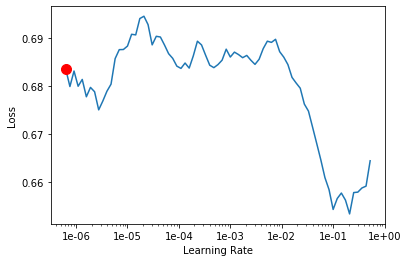

In [34]:
learn.recorder.plot(skip_end = 10, suggestion=True)

In [35]:
lr = 1e-2

In [36]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,time
0,0.510623,0.533349,0.693800,0.774364,0.636878,00:29
1,0.477278,0.478411,0.815600,0.464919,0.893188,00:28
2,0.486570,0.481027,0.768400,0.631601,0.776532,00:27
3,0.480258,0.466620,0.830300,0.426215,0.928432,00:28
4,0.466139,0.464813,0.827600,0.459537,0.915631,00:28
5,0.459403,0.453312,0.824400,0.466175,0.904988,00:28
6,0.462822,0.444964,0.792400,0.618619,0.812562,00:28
7,0.439536,0.439247,0.811500,0.584847,0.850133,00:28
8,0.440421,0.437284,0.812700,0.584885,0.852186,00:28
9,0.449534,0.436189,0.813100,0.585816,0.852246,00:28


In [31]:
#learn.load("GC_peak_class")

Learner(data=DataBunch;

Train: LabelList (34829 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (10000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,1,1
Path: .;

Test: None, model=PaperModel(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(8, 1), stride=(1, 1), padding=(3, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(6, 1), stride=(1, 1), padding=(3, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running

## Results

In [32]:
interp = ClassificationInterpretation.from_learner(learn, ds_type = DatasetType.Valid)

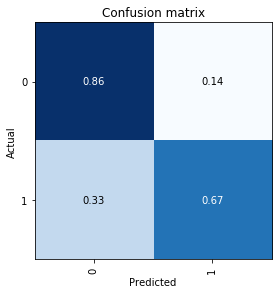

In [33]:
interp.plot_confusion_matrix(normalize = True)

In [34]:
confusion = interp.confusion_matrix()

In [35]:
#Above accuracy
confusion[1][1] / confusion[1].sum()

0.6709401709401709

In [36]:
#Not above accuracy
confusion[0][0] / confusion[0].sum()

0.8565274151436031

## Explainability

In [37]:
from fastai.callbacks.hooks import *

In [38]:
m = learn.model.eval()

In [39]:
m

PaperModel(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(8, 1), stride=(1, 1), padding=(3, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(6, 1), stride=(1, 1), padding=(3, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4)
    (12): Conv1d(1, 1, kernel_size=(5, 19), stride=(1,), padding=(2, 9))
    (13): ReLU()
    (14): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.4)
  )
  (lins): Sequential(
    (0): Linear(in_features=760, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=T

In [40]:
relu = nn.ReLU()

In [41]:
#runs the bigen xb through the model and hooks the activations and the gradients.
def hooked_backward(cat, xb, layer):
    with hook_output(m.convs[layer]) as hook_a: 
        with hook_output(m.convs[layer], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [42]:
#Returns the grad_cam at the given layer on the given item (x value)
def get_grad_cam(data, item, layer, m, y_actual = True):
    y = item[1]
    if not y_actual:
        y = get_pred(item)
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb, layer)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    
    return  np.transpose((acts*grad_chan[...,None,None]).mean(0))

In [43]:
#Makes each row in the array percents of the row sum.
def percentize(features):
    for i in range(len(features)):
        features[i] = np.array([features[i][j] / features[i].max() for j in range(len(features[i]))])
        
    return features

In [44]:
#Returns the models prediction on the given item.
def get_pred(item):
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    return int(np.argmax(m(xb)[0]))

In [45]:
#Draws the given x with the given heat map over it.
def draw_map(x, heat_map, save = None):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.plot(x)

    # Get second axis
    ax2 = ax.twinx()
    plt.imshow(np.repeat(heat_map[None], 100, 0), alpha = 0.6, interpolation='bilinear')
    plt.colorbar()
    plt.show()
    if save != None:
        fig.savefig(path/"ims"/save)

In [46]:
def d_m(x, heat_map, save = None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    for ax in axs.flat:
        im = ax.imshow(np.repeat(heat_map[None], 100, 0), alpha = 0.6, interpolation='bilinear', vmin = 0, vmax = 100)
        ax2 = ax.twinx()
        ax2.plot(x)
    fig.colorbar(im, ax=axs, shrink=0.6)
    plt.plot()

In [47]:
#Plots the average x from the items and grad cam results from the gs.
def plot_avg_var_map(var, items, gs, targ, save = None):
    total = []
    for piece in items:
        if int(piece[1]) == targ:
            total.append(np.array(piece[0].data[0][:,var]))
    total = np.array(total)
    x = total.mean(0)
    d_m(x, gs.mean(0)[var], save = save)

In [48]:
def get_avg_var_map(var, items, gs, targ, save = None):
    total = []
    for piece in items:
        if int(piece[1]) == targ:
            total.append(np.array(piece[0].data[0][:,var]))
    total = np.array(total)
    x = total.mean(0)
    return [x, gs.mean(0)[var]]

In [49]:
def draw_variable(item, g, var):
    x = item[0].data[0][:, var]
    draw_map(x, g[var])

In [58]:
#Gets the grad_cams for each piece of the data's validation set.
#Split into grad cams for above and not above data.
def get_grad_cams(data):
    f_res = []
    t_res = []
    for item in data.valid_ds:
        g = get_grad_cam(data, item, 5, m, y_actual = False)
        g = relu(g)
        if get_pred(item) == 0:
            f_res.append(np.array(g))
        else:
            t_res.append(np.array(g))
    return np.array(f_res), np.array(t_res)

In [59]:
#Returns variable importance for predicting false and predicting true.
def get_var_import(f_gs, t_gs):
    fs = []
    ts = []
    for g in f_gs:
        fs.append(list(g.mean(1)))
    for g in t_gs:
        ts.append(list(g.mean(1)))
    return np.array(fs).mean(0), np.array(ts).mean(0)

In [76]:
def get_most_imp(imps, num_most):
    imps = imps.copy()
    most_imp = []
    for i in range(num_most):
        tmp = imps.argmax()
        most_imp.append(tmp)
        imps[tmp] = 0
    
    return most_imp

In [60]:
var_names = list(columns[:16]) + list(columns[-3:])

In [61]:
%%time
f_gs, t_gs = get_grad_cams(data)

Wall time: 2min 39s


In [62]:
f_gs.mean(0).shape

(19, 40)

In [63]:
f_imp, t_imp = get_var_import(f_gs, t_gs)

In [64]:
f_imp = (f_imp / f_imp.sum()) * 100

In [65]:
t_imp = (t_imp / t_imp.sum()) * 100

In [66]:
f_imp

array([12.371678,  6.738292,  5.378302,  3.547582,  2.821011, 13.853704,  6.90596 ,  4.681178,  2.523394,  2.342466,
        4.110927,  2.480498,  1.841888,  1.920498,  3.254723, 16.06617 ,  4.34477 ,  2.668641,  2.148314],
      dtype=float32)

In [83]:
t_imp

array([ 3.191189,  2.819654,  1.697583,  2.254441,  4.259104,  2.128063,  4.707511,  4.779039,  6.939211,  8.813163,
       15.381522,  7.457347,  4.260192,  2.856154,  1.871351, 13.570042,  2.405565,  5.501666,  5.107211],
      dtype=float32)

In [79]:
f_most_imp = get_most_imp(f_imp, 4)

In [80]:
f_most_imp

[15, 5, 0, 6]

In [81]:
t_most_imp = get_most_imp(t_imp, 4)

In [82]:
t_most_imp

[10, 15, 9, 11]

In [84]:
variables = f_most_imp + t_most_imp

In [86]:
variables.sort()

In [90]:
variables = np.unique(np.array(variables))

In [91]:
variables

array([ 0,  5,  6,  9, 10, 11, 15], dtype=int64)

In [92]:
#contains: [average x, average GradCam, variable index] for true and false of each important variable.
variable_info = []
for v in variables:
    variable_info.append(get_avg_var_map(v, data.valid_ds, t_gs, 1) + [v])
    variable_info.append(get_avg_var_map(v, data.valid_ds, f_gs, 0) + [v])

In [95]:
len(variable_info)

14

In [110]:
min_grad = min([variable_info[i][1].min() for i in range(len(variable_info))])
max_grad = max([variable_info[i][1].max() for i in range(len(variable_info))])

In [99]:
y_lims = []
for i in range(0, 13, 2):
    y_lims.append([min([variable_info[i][0].min() for i in range(i, i + 2)]), max([variable_info[i][0].max() for i in range(i, i + 2)])])

In [100]:
y_lims

[[0.13691898, 1.0331132],
 [0.24883245, 1.114335],
 [0.38878414, 0.9522769],
 [0.9129665, 0.99572784],
 [9.367521, 35.74359],
 [12.166673, 24.677906],
 [-2.302658, 1.5971371]]

In [103]:
ys = [int(y) for y in data.valid_ds.y]

In [104]:
trues = np.where(np.array(ys) == 1)[0]
np.random.shuffle(trues)

In [105]:
falses = np.where(np.array(ys) == 0)[0]
np.random.shuffle(falses)

In [106]:
true_traces = np.array([np.array(data.valid_ds[i][0].data[0]) for i in trues])
false_traces = np.array([np.array(data.valid_ds[i][0].data[0]) for i in falses])

In [107]:
traces = [true_traces[:20], false_traces[:20]]

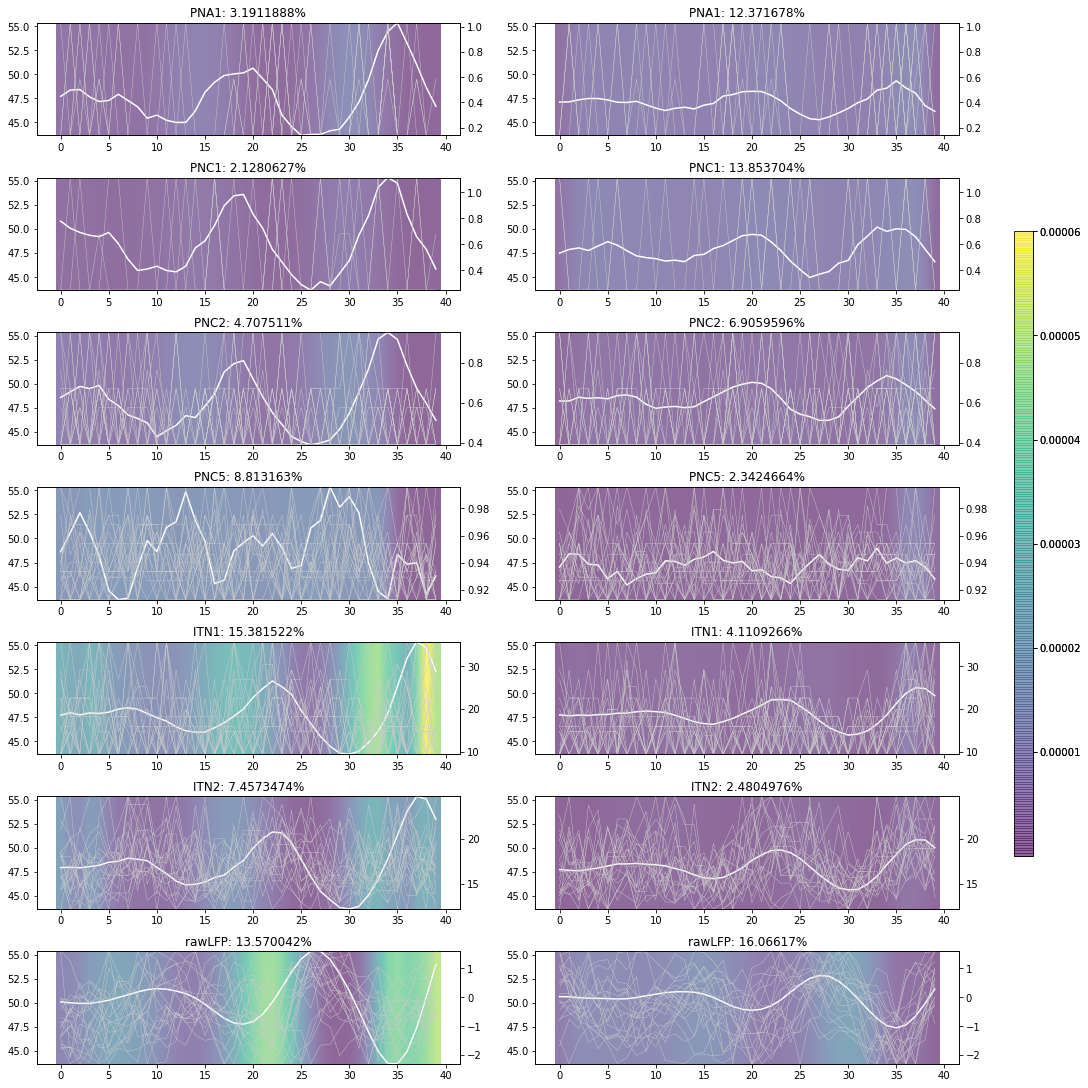

In [109]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    im = ax.imshow(np.repeat(variable_info[count][1][None], 100, 0), origin = "lower", alpha = 0.6, 
                   interpolation='bilinear', vmin = min_grad, vmax = max_grad)
    if count % 2 == 0:
        title = var_names[variable_info[count][2]] + ": " + str(t_imp[variable_info[count][2]]) + "%"
    else:
        title = var_names[variable_info[count][2]] + ": " + str(f_imp[variable_info[count][2]]) + "%"
    ax.set_title(title)
    ax2 = ax.twinx()
    ax2.set_ylim(y_lims[count//2])
    ax2.plot(variable_info[count][0], color = "w")
    for trace in traces[count % 2 == 0]:
        trace = trace[:, variable_info[count][2]]
        trace = np.interp(trace, (trace.min(), trace.max()), y_lims[count//2])
        ax2.plot(trace, linewidth = 0.4, color = [0.8, 0.8, 0.8])
    count += 1
fig.colorbar(im, ax=axs, shrink=0.6)
fig.colorbar(im, ax=axs, shrink=0.6)
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')

In [115]:
t_min_grad = min([variable_info[i][1].min() for i in range(0, len(variable_info), 2)])
t_max_grad = max([variable_info[i][1].max() for i in range(0, len(variable_info), 2)])

In [121]:
f_min_grad = min([variable_info[i][1].min() for i in range(1, len(variable_info), 2)])
f_max_grad = max([variable_info[i][1].max() for i in range(1, len(variable_info), 2)])

In [118]:
t_min_grad, t_max_grad

(5.4999898e-08, 6.0021008e-05)

In [122]:
f_min_grad, f_max_grad

(9.4176045e-08, 2.1041698e-05)

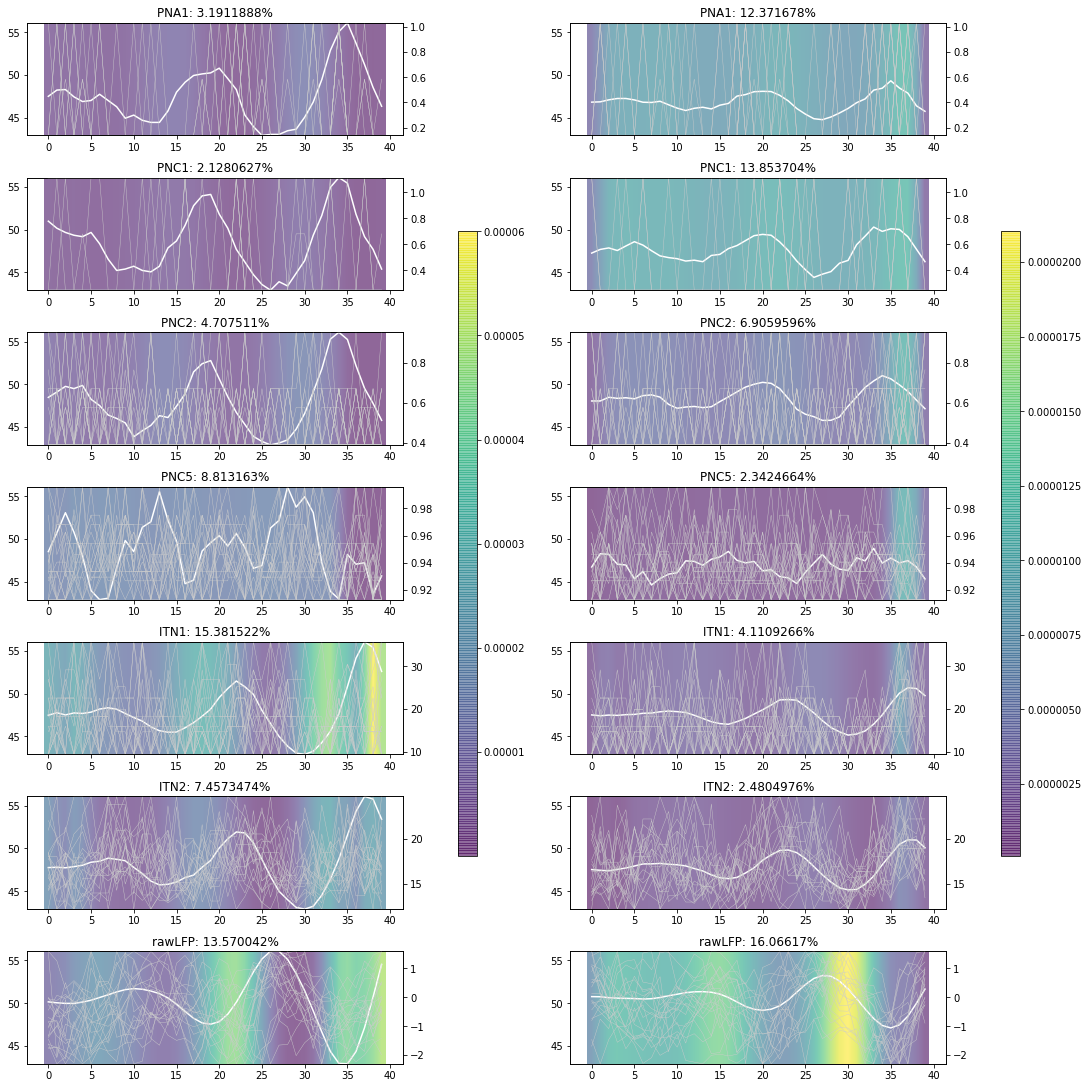

In [134]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15), constrained_layout=True)
count = 0
extent = [0, 40, 0, 1]
for ax in axs.flat:
    if count % 2 == 0:
        t_im = ax.imshow(np.repeat(variable_info[count][1][None], 100, 0), origin = "lower", alpha = 0.6, 
                   interpolation='bilinear', vmin = t_min_grad, vmax = t_max_grad)
        title = var_names[variable_info[count][2]] + ": " + str(t_imp[variable_info[count][2]]) + "%"
    else:
        f_im = ax.imshow(np.repeat(variable_info[count][1][None], 100, 0), origin = "lower", alpha = 0.6, 
                   interpolation='bilinear', vmin = f_min_grad, vmax = f_max_grad)
        title = var_names[variable_info[count][2]] + ": " + str(f_imp[variable_info[count][2]]) + "%"
    ax.set_title(title)
    ax2 = ax.twinx()
    ax2.set_ylim(y_lims[count//2])
    ax2.plot(variable_info[count][0], color = "w")
    for trace in traces[count % 2 == 0]:
        trace = trace[:, variable_info[count][2]]
        trace = np.interp(trace, (trace.min(), trace.max()), y_lims[count//2])
        ax2.plot(trace, linewidth = 0.4, color = [0.8, 0.8, 0.8])
    count += 1
t_cb = plt.colorbar(t_im, ax=axs.flat[[i for i in range(0, len(axs.flat), 2)]], shrink=0.6)
f_cb = plt.colorbar(f_im, ax=axs.flat[[i for i in range(1, len(axs.flat), 2)]], shrink=0.6)
plt.show()
#plt.savefig(path/"results.pdf", format='pdf')